# Time Ordered Exponential

This is a short example to examine the error in a numerically constructed time-ordered exponential. The exponential represents the time-evolution of a harmonically driven Hamiltonian of a 2-level system. We divide the time interval into $n$ sub-intervals and propagate ordinary exponentials with the Hamiltonian held constant to its value at the beginning of the interval. The ordered product of such unitaries yields the time-evolution of a quantum state. We then differentiate this state and compute its residual from the Schroedinger equation. We show that the residual is first order in the time step as expected. 

The Hamiltonian is,

$$
 H(t) = \frac{1}{2} E_0 Z + \frac{1}{2} V_0 \sin(\omega t)X
$$

We replace $H(t)$ by a piecewise constant function in time intervals $[t,t+\delta t]$. The function is held at its value at the beginning of the interval. Therefore, the unitary evolution operator to propagate the quantum state from time $t$ to time $t+\delta t$ is,

$$
U_{\delta t}(t)\equiv\exp{\left[-i \frac{\delta t}{\hbar} H(t)\right]} = I \cos(\Omega(t)\delta t) - i \left[E_0 Z + V_0 \sin(\omega t) X\right] \frac{\sin(\Omega(t)\delta t)}{2 \Omega(t)},
$$

where we have defined,

$$
\Omega(t) = \frac{1}{2\hbar}\sqrt{E_0^2 + V_0^2 \sin^2(\omega t)}.
$$

We now use this formula to propagate the quantum state from an initial time $t = 0$ to an arbitrary final time $t$. We divide the interval $[0,t]$ into $n$ equal parts so that $t = 0 + n\delta t$. The unitary evolution with the piecewise constant approximation to the Hamiltonian is then, 

$$
\mathcal{T} \exp{\left[\frac{-i}{\hbar}\int_{t_0}^{t} H(t')dt'\right]} = U_{\delta t}(n\delta t)\cdots U_{\delta t}(2\delta t)U_{\delta t}(\delta t)U_{\delta t}(0).
$$

To propagate a quantum state from initial value $\psi(t_0)$ to an arbitrary time $\psi(t)$ later, the above formula gives the recurrence relation,

$$
\psi(t = 0) = \psi_0,
$$

$$
\psi(t + \delta t) = U_{\delta t}(t) \psi(t).
$$

In [1]:
import numpy as np
from math import pi
from matplotlib import pyplot as plt

Below we implement 3 functions to realize the time-ordered exponentials above.

In [2]:
# We will use time in energy units so that hbar=1
# Pauli Z matrix
Z = np.array([[1,0],[0,-1]])
# Pauli X matrix
X = np.array([[0,1],[1, 0]])

def Hamiltonian(t, E0, V0, omega):
    """Implements the Hamiltonian function H(t) above
    """
    H = E0/2 * Z + V0 / 2 * np.sin(omega*t) * X
    return H

def Omega(t, E0, V0, omega):
    return 1/2 * np.sqrt( E0**2 + V0**2 * np.sin(omega*t)**2 )

def UnitaryStep(dt, t, E0, V0, omega):
    """Implements the single step for unitary evolution, U_{delta t}(t) above.
    """
    W = Omega(t,E0,V0,omega)
    H = Hamiltonian(t,E0,V0,omega)
    U = np.cos(W*dt)*np.eye(2) - 1j* np.sin(W*dt)/ W * H
    return U
    
def PropagateState(psi0, tmax, E0, V0, omega, dt):
    """Implements the evolution of initial state to final state as shown in the last equation in the introduction.
    """
    t = np.arange(0, tmax, dt)
    psi = np.zeros((len(t), 2),dtype=complex)
    psi[0] = psi0
    for i in range(1,len(t)):
        U1 = UnitaryStep(t[i]-t[i-1], t[i-1], E0, V0, omega)
        psi[i] = U1 @ psi[i-1]
    return psi, t

The next three functions implement the substitution of

In [3]:
def dpsidt(t , psi, E0, V0, omega):
    H = Hamiltonian(t,E0, V0, omega)
    dy = -1j * (H @ psi)
    return dy

def EvalResidual(t, psi, E0, V0, omega):
    dydt = np.gradient(psi, t[1]-t[0], axis=0)[1:-1]
    rhs = np.array([-1j*Hamiltonian(t[i],E0, V0, omega) @ psi[i] for i in range(1,len(t)-1)])
    res = np.abs(dydt-rhs).max(axis=1)
    return res

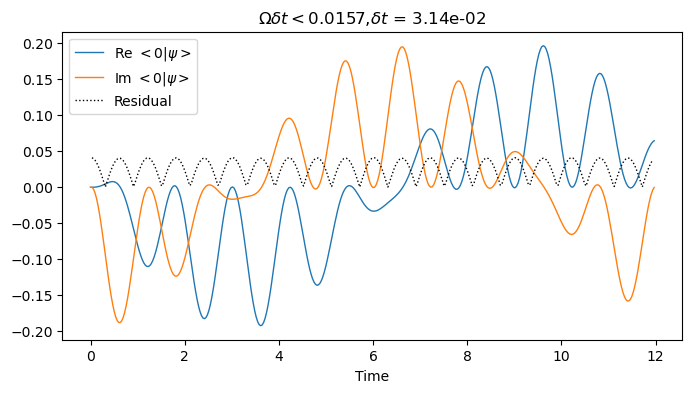

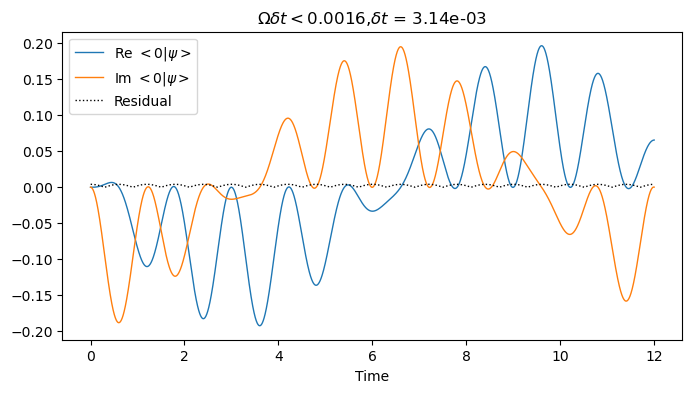

In [11]:
T = 12
params = E0, V0, omega = 1, 1, 20*pi/T
Wmax = Omega(T/4, *params)
dt = min(T, np.pi/Wmax/2)
psi0 = np.array([0,1],dtype=complex)
Res=[]
for dtf in [1e-2, 1e-3]:
    psi, t = PropagateState(psi0, T, *params, dtf * dt)
    residual = EvalResidual(t, psi, *params)
    Res += [(dtf*dt, residual.max())]
    fig,ax=plt.subplots(ncols=1,figsize=(8,4))
    ax.grid(False)
    ax.plot(t, psi[:,0].real, linewidth=1, label='Re $<0 | \psi>$')
    ax.plot(t, psi[:,0].imag, linewidth=1, label='Im $<0 | \psi>$')
    ax.plot(t[1:-1], residual, linewidth=1, color='black',linestyle=':', label='Residual')
    ax.set_title('$\Omega\delta t < {:.4f}$,$\delta t$ = {:.2e}'.format(Wmax*dt*dtf,dt*dtf))
    ax.legend()
    ax.set_xlabel('Time')
